In [15]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
import numpy as np
# import tension tools utilities:
from tensiometer import utilities

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Create the Mb prior chains
ndim = 1 # number of dimensions
nsamp = 10000 # number of samples
nchains = 8 # number of chains
# helper function to compute the likelihood:
def helper_gaussian_log_like( samps, mean, invcov ):
    _diff = samps-mean
    return (_diff.dot(invcov)*_diff).sum(axis=1)
# first data set:
mean_1 = np.array([-19.253])
cov_1 = np.array([[0.0007289999999999999]]) #0.027**2
samps_1 = np.random.multivariate_normal(mean_1, cov_1, size=nchains*nsamp)
log_like_1 = helper_gaussian_log_like(samps_1, mean_1, np.linalg.inv(cov_1))
names = ["M"]
labels = ["M"]
# initialize the GetDist chains:
chain_Mb = MCSamples(samples=samps_1, loglikes=log_like_1, names=names, labels=labels, label='first')
# separate the chains so that we can have rough convergence estimates:
for chain in [chain_Mb]:
    chain.chain_offsets = [i*nsamp for i in range(nchains+1)]
# Gelman–Rubin (GetDist returns R-1)
print("R-1:", chain_Mb.getGelmanRubin())

R-1: 8.449592510267991e-05


In [17]:
# load the EDE / SPA+LBS chains:
root_MP="/Users/vpoulin/Dropbox/Labo/chains_EDE_SPT/MP_chains/"
root_MP="/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/varying_zc_npipe/"
# samp_EDE = getdist.mcsamples.loadMCSamples('%s%s' % (root_MP+'SPAlite_LBS_OLE_2025-12-05/', '2025-12-09_4000000_'), settings={'ignore_rows':0.3})
samp_EDE = getdist.mcsamples.loadMCSamples('%s%s' % (root_MP+'2_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2026-02-02/', '2026-02-02_1000000_'), settings={'ignore_rows':0.3})

chain1 = chain_Mb
chain2 = samp_EDE

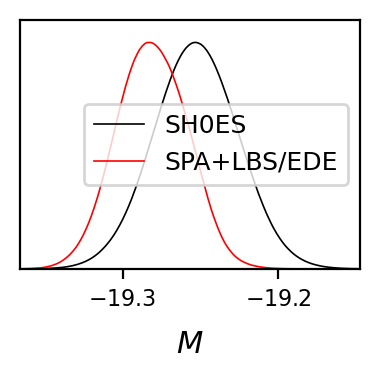

In [18]:
from tensiometer import mcmc_tension
# set single thread for running on small machines:
mcmc_tension.n_threads = 1
diff_chain = mcmc_tension.parameter_diff_chain(chain1, chain2, boost=1)
g = plots.get_subplot_plotter()
g.plot_1d([chain1, chain2],'M', legend_labels=['SH0ES','SPA+LBS/EDE'])
g.add_legend(['SH0ES','SPA+LBS/EDE']);


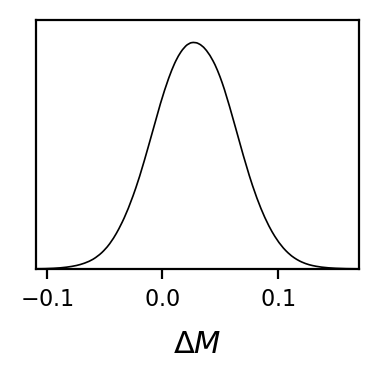

In [19]:

g = plots.get_subplot_plotter()
g.plot_1d(diff_chain,'delta_M')


In [22]:
#Gaussian tension estimate (any number of dimensions)
from tensiometer import gaussian_tension
# start with Q_DM:
Q_DM = gaussian_tension.Q_DM(chain1, chain2, param_names=['M'])
# compute probability:
Q_DM_P = scipy.stats.chi2.cdf(*Q_DM)
# print results:
print(f'Q_DM = {Q_DM[0]:.3f} with dofs {Q_DM[1]:.3f}')
# print(f'Q_DM probability = {Q_DM_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_DM_P):.3f}')



Q_DM = 0.639 with dofs 1.000


In [23]:
#non-Gaussian tension estimate in 1D
diff_chain_ND = mcmc_tension.parameter_diff_chain(chain1, chain2, boost=1)

exact_shift_P_1, exact_shift_low_1, exact_shift_hi_1 = mcmc_tension.kde_parameter_shift_1D_fft(diff_chain, feedback=1, param_names=['delta_M'])
print(f'Shift probability considering all parameters = {exact_shift_P_1:.5f} +{exact_shift_hi_1-exact_shift_P_1:.5f} -{exact_shift_P_1-exact_shift_low_1:.5f}')
# turn the result to effective number of sigmas:
# print(f'    n_sigma = {utilities.from_confidence_to_sigma(exact_shift_P_1):.3f}')

Time taken for 1D FFT-KDE calculation: 0.0 (s)
Shift probability considering all parameters = 0.57019 +0.00070 -0.00070


AttributeError: module 'tensiometer.utilities' has no attribute 'from_confidence_to_sigma'

In [ ]:
#non-Gaussian tension estimate in more than 1D
exact_shift_P_2, exact_shift_low_2, exact_shift_hi_2 = mcmc_tension.kde_parameter_shift(diff_chain_ND, feedback=0, param_names=['delta_sigma8', 'delta_omegam','delta_theta_BAO_DES'])
print(f'Shift probability considering selected parameters = {exact_shift_P_2:.5f} +{exact_shift_hi_2-exact_shift_P_2:.5f} -{exact_shift_P_2-exact_shift_low_2:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(exact_shift_P_2):.3f}')

In [ ]:
from MCEvidence import MCEvidence
MLE = MCEvidence('/Users/vpoulin/Dropbox/Labo/chains_EDE_SPT/MP_chains/SPAlite_LBSMb_OLE_2025-12-05/2025-12-06_3000000_',ndim=10).evidence()
#   verbose=True,
#    prewhiten=False,
 #   nproc=1,pos_lnp=True)